In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'

In [2]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses, thousands=r',') # pass thousands parameters to parse numbers
prescribers = pd.read_csv(file_prescribers)

In [3]:
overdoses = overdoses.set_index('State')

# Data wrangling steps 

A summary of the data cleaning steps taken during this project 

Quick summary of the different files: 
* overdoses.csv contains opioid overdose data for 2014
* opioids.csv contains drug and generic names for various prescription opioids. 
* prescriber-info.csv contains (sort of) anonymized prescriber data for 25,000 drug prescribers along with the number of prescriptions they wrote for the 250 most commonly prescribed drugs in 2014, and information about whether or not they're opioid prescribers. 

In [4]:
overdoses.head()

,Population,Deaths,Abbrev
State,,,
Alabama,4833722,723,AL
Alaska,735132,124,AK
Arizona,6626624,1211,AZ
Arkansas,2959373,356,AR
California,38332521,4521,CA


In [5]:
prescribers.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [6]:
#Rename prescribers.State because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);

In [12]:
prescribers.shape

(25000, 256)

## Outliers: 

Next we explore different outliers.

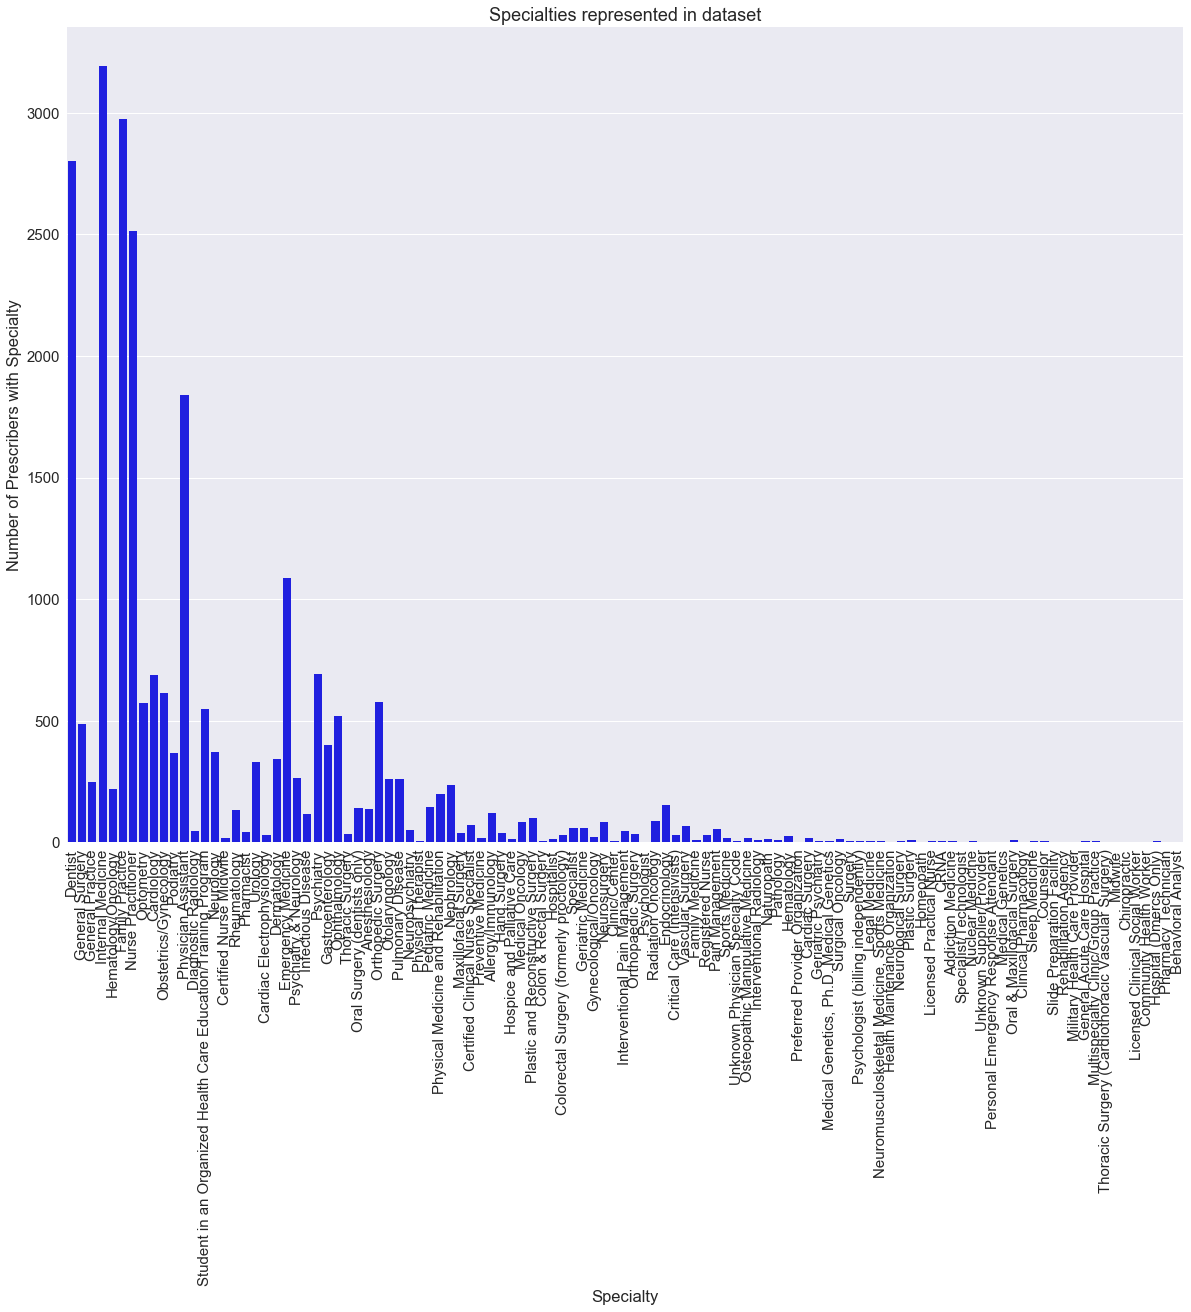

In [26]:
_=sns.set(font_scale=1.5)
_ = plt.subplots(figsize=(20,15))
_ = sns.countplot(x='Specialty', data = prescribers, color='blue')
_ = plt.title('Specialties represented in Dataset')
locs, labels = plt.xticks()
_ = plt.xticks(locs, prescribers.Specialty.unique(), rotation=90)
_ = plt.ylabel('Number of Prescribers with Specialty')

In [11]:
prescribers.Specialty.value_counts()

Internal Medicine                                                 3194
Family Practice                                                   2975
Dentist                                                           2800
Nurse Practitioner                                                2512
Physician Assistant                                               1839
Emergency Medicine                                                1087
Psychiatry                                                         691
Cardiology                                                         688
Obstetrics/Gynecology                                              615
Orthopedic Surgery                                                 575
Optometry                                                          571
Student in an Organized Health Care Education/Training Program     547
Ophthalmology                                                      519
General Surgery                                                    487
Gastro

The end goal of this project is to predict prescription demand for the 250 most commonly prescribed drugs we have data for. We hope to use medical specialty as a feature here: that means that those specialties that are not well-represented in the datasest cannot be accurately modeled. 

In [16]:
P = prescribers.Specialty.value_counts()
len(P.where(P> 50).dropna())

43

There are 43 specialties that are reasonably well-represented in the dataset. We will only use these specialties in our model. The specialties are: 

In [17]:
P.where(P> 50).dropna()

Internal Medicine                                                 3194.0
Family Practice                                                   2975.0
Dentist                                                           2800.0
Nurse Practitioner                                                2512.0
Physician Assistant                                               1839.0
Emergency Medicine                                                1087.0
Psychiatry                                                         691.0
Cardiology                                                         688.0
Obstetrics/Gynecology                                              615.0
Orthopedic Surgery                                                 575.0
Optometry                                                          571.0
Student in an Organized Health Care Education/Training Program     547.0
Ophthalmology                                                      519.0
General Surgery                                    

Some US Territories are also not well-represented in the sample

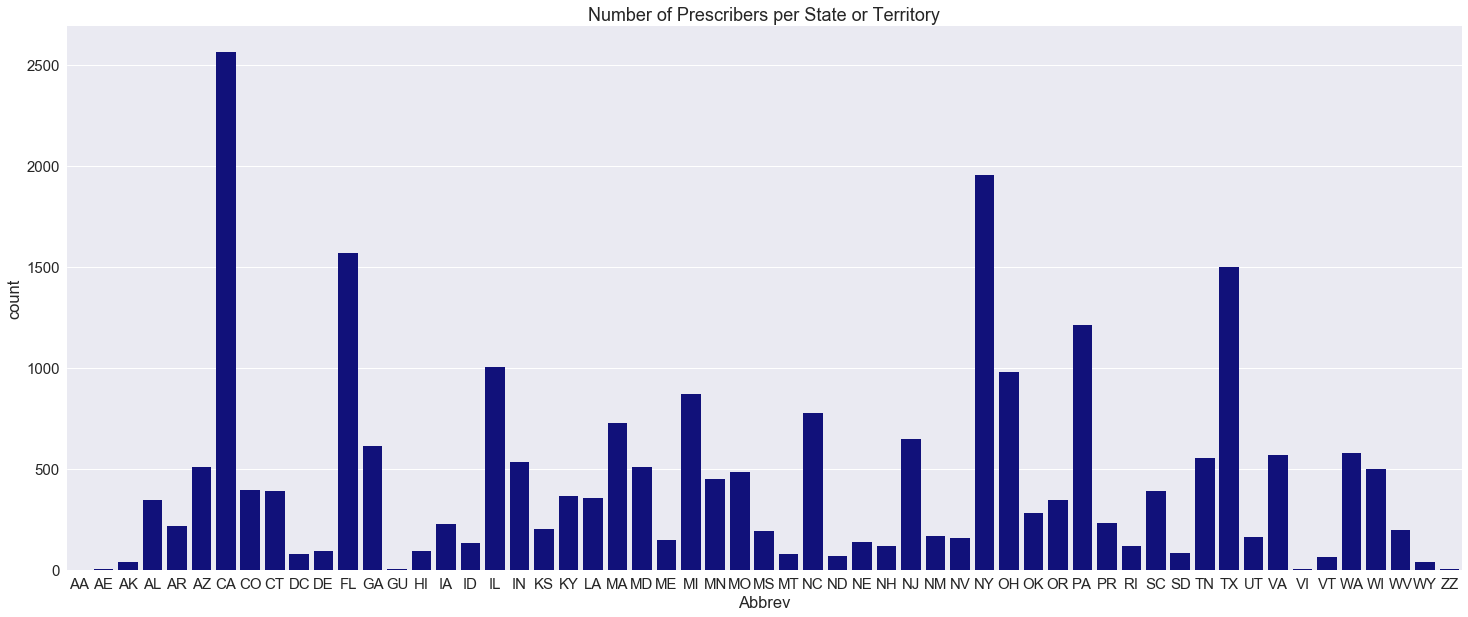

In [27]:
_ = plt.subplots(figsize=(25,10))
practitioner_count = sns.countplot(x='Abbrev', data=prescribers.sort_values('Abbrev'), color = 'darkblue')
_ = practitioner_count.set_title('Number of Prescribers per State or Territory')

### Legend for some unfamiliar abbreviations:
* AA - Armed Forces Americas 
* AE - Armed Forces Africa
* GU - Guam
* VI - US Virgin Islands
* ZZ - ???

In [36]:
S = prescribers.Abbrev.value_counts()
S.where(S < 50).dropna()

AK    39.0
WY    38.0
VI     3.0
GU     2.0
AE     2.0
ZZ     2.0
AA     1.0
Name: Abbrev, dtype: float64

The US territories such as Guam (GU) and the US Virgin Islands (VI) have so few providers 

Additionally, it is not clear what state or territory ZZ refers to. If prescriber state will be used as a feature in our model, territories should be ignored. It's also worth considering if AK and WY should also be excluded. 

## The parameter Opioid.Prescriber 

In [30]:
prescribers[['NPI', 'Specialty', 'Abbrev', 'Opioid.Prescriber']].head()

,NPI,Specialty,Abbrev,Opioid.Prescriber
0,1710982582,Dentist,TX,1
1,1245278100,General Surgery,AL,1
2,1427182161,General Practice,NY,0
3,1669567541,Internal Medicine,AZ,1
4,1679650949,Hematology/Oncology,NV,1


A provider is classified as an opioid prescriber if they prescribed any opioid within the last year. It is not clear from the dataset description whether this is represented in the tracked prescriptions. 

It is also not clear which of the 250 most commonly-prescribed drugs are opioids. Using the opioids dataframe, we search for commonly prescribed opioids. 

In [7]:
opioids.head()

,Drug Name,Generic Name
0,ABSTRAL,FENTANYL CITRATE
1,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE
2,ACTIQ,FENTANYL CITRATE
3,ASCOMP WITH CODEINE,CODEINE/BUTALBITAL/ASA/CAFFEIN
4,ASPIRIN-CAFFEINE-DIHYDROCODEIN,DIHYDROCODEINE/ASPIRIN/CAFFEIN


In [31]:
tracked_drugs = 
opioid_names = opioids['Drug Name']
detected_opioids = set(tracked_drugs).intersection(set(opioid_names))
print(detected_opioids)

NameError: name 'tracked_drugs' is not defined